In [ ]:
import numpy as np
import pandas as pd
import math
import datetime

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from plotly.offline import init_notebook_mode, iplot, plot
import plotly.express as px
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error

from warnings import simplefilter
simplefilter("ignore")

from tqdm.notebook import tqdm_notebook

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(12, 6),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

import random
import os

SEED = 2021
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(SEED)

from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import acf, pacf

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

#  My other notebooks :
* [Basic EDA with visualization  and animated polar plot](https://www.kaggle.com/code/martynovandrey/tps-mar-22-step-0-data-exploration-animation) 
* [Looking for special values, EDA](https://www.kaggle.com/code/martynovandrey/tps-mar-22-step-0-1-special-values)
* [Features selection](https://www.kaggle.com/code/martynovandrey/tps-mar-22-fe-the-less-the-better)
* [MultiOutput regressor, 65 targets in one](https://www.kaggle.com/code/martynovandrey/tps-mar-22-multioutput-cat-modeless)
* [Hybrid regressor, two step model](https://www.kaggle.com/code/martynovandrey/tps-mar-22-hybrid-regressors)
* [Multimodel regression, blendig, postprocessing - my best public score so far](https://www.kaggle.com/code/martynovandrey/tps-mar-22-fe-model-selection)
* [How to use special values to improve submission, dataset shared](https://www.kaggle.com/code/martynovandrey/tps-mar-22-don-t-forget-special-values)

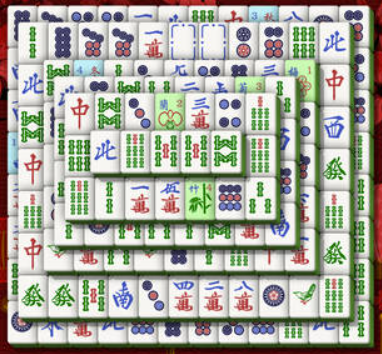

# Goal  
I'm to try some feature engineering and selection techniques from Kaggle courses 
* Mutual information
* Permutation importance
* SHAP
* PCA  
and see if it's possible to improve public score by removing unimportant features *(the answer "yes")*.

# Read data

In [ ]:
df_train = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv', index_col="row_id", parse_dates=['time'])
df_test = pd.read_csv('../input/tabular-playground-series-mar-2022/test.csv', index_col="row_id", parse_dates=['time'])
df_train_idx = df_train.index
df_test_idx = df_test.index

# Date and time features

In [ ]:
def add_datetime_features(df):
    df['month']   = df['time'].dt.month
    df['day']     = df['time'].dt.day
    df['weekday'] = df['time'].dt.weekday
    df['weekend'] = (df['time'].dt.weekday >= 5)
    df['hour']    = df['time'].dt.hour
    df['minute']  = df['time'].dt.minute
    df['afternoon'] = df['hour'] >= 12
    
    # number of 20' period in a day
    df['moment']  = df['time'].dt.hour * 3 + df['time'].dt.minute // 20 

# Missing time points
* Let's gey rid of missing time points to make the time axis continuous

# x, y, direction -> road

In [ ]:
df_train['road'] = df_train['x'].astype(str) + df_train['y'].astype(str) + df_train['direction']
df_test['road']  = df_test['x'].astype(str) + df_test['y'].astype(str) + df_test['direction']

le = LabelEncoder()
df_train['road'] = le.fit_transform(df_train['road'])
df_test['road']  = le.transform(df_test['road'])

df_train = df_train.drop(['x', 'y', 'direction'], axis=1)
df_test = df_test.drop(['x', 'y', 'direction'], axis=1)

add_datetime_features(df_train)
add_datetime_features(df_test)

# Congestion median, std, min, max, morning average features

In [ ]:
medians = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.median().astype(int)).reset_index()
medians = medians.rename(columns={'congestion':'median'})
df_train = df_train.merge(medians, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test = df_test.merge(medians, on=['road', 'weekday', 'hour', 'minute'], how='left')

In [ ]:
stds = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.std().astype(int)).reset_index()
stds = stds.rename(columns={'congestion':'std'})
df_train = df_train.merge(stds, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test = df_test.merge(stds, on=['road', 'weekday', 'hour', 'minute'], how='left')

In [ ]:
mins = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.min().astype(int)).reset_index()
mins = mins.rename(columns={'congestion':'min'})
df_train = df_train.merge(mins, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test = df_test.merge(mins, on=['road', 'weekday', 'hour', 'minute'], how='left')

In [ ]:
maxs = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.max().astype(int)).reset_index()
maxs = maxs.rename(columns={'congestion':'max'})
df_train = df_train.merge(maxs, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test = df_test.merge(maxs, on=['road', 'weekday', 'hour', 'minute'], how='left')

In [ ]:
df_mornings = df_train[(df_train.hour >= 6) & (df_train.hour < 12)]
morning_avgs = pd.DataFrame(df_mornings.groupby(['month', 'day', 'road']).congestion.median().astype(int)).reset_index()
morning_avgs = morning_avgs.rename(columns={'congestion':'morning_avg'})
df_train = df_train.merge(morning_avgs, on=['month', 'day', 'road'], how='left')
df_test = df_test.merge(morning_avgs, on=['month', 'day', 'road'], how='left')

In [ ]:
quantile25 = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.quantile([.25]).astype(int)).reset_index()
quantile25 = quantile25.rename(columns={'congestion':'quantile25'}).drop(['level_4'], axis=1)
df_train = df_train.merge(quantile25, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test = df_test.merge(quantile25, on=['road', 'weekday', 'hour', 'minute'], how='left')

In [ ]:
quantile75 = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.quantile([.75]).astype(int)).reset_index()
quantile75 = quantile75.rename(columns={'congestion':'quantile75'}).drop(['level_4'], axis=1)
df_train = df_train.merge(quantile75, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test = df_test.merge(quantile75, on=['road', 'weekday', 'hour', 'minute'], how='left')

In [ ]:
df_test.index = df_test_idx

# Time lags

In [ ]:
for delta in range(1,8):
    day = df_train.copy()
    day['time'] = day['time'] + pd.Timedelta(delta, unit="d")
    name = f'lag_{delta}'
    day = day.rename(columns={'congestion':name})[['time', 'road', name]]
    df_train = df_train.merge(day, on=['time', 'road'], how='left')
    df_test = df_test.merge(day, on=['time', 'road'], how='left')

In [ ]:
lags = list(df_train.columns)[18:]
print(lags)

In [ ]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}, -{lag//72} days", xlabel=x_.name, ylabel=y_.name)
    return ax


### Take one roadway as a sample

In [ ]:
road_num = 12
print('Roadway', le.inverse_transform([road_num])[0])
sample = df_train[(df_train.road == road_num) & (df_train.weekday == 0)]

In [ ]:
def deseason(df):
    df = df.reset_index(drop=True).reset_index().rename(columns={'index':'tic'})
    X_tic = df[['tic']]
    y = df.set_index('tic').loc[:, 'congestion'].squeeze()
    model = LinearRegression(fit_intercept=False)
    model.fit(X_tic, y)
    y_deseason = y - model.predict(X_tic)
    y_deseason.name = 'congestion_deseasoned'
    return y_deseason    

In [ ]:
y_deseason = deseason(sample)

ax = y_deseason.plot()
ax.set_title("Congestion (deseasonalized)");

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(24, 4))
lag_days = 1
for ax, lag in zip(axs.flat, lags):
#     ax = lagplot(sample['congestion'], lag=lag_days*72, ax=ax)
    ax = lagplot(y_deseason, lag=lag_days*72, ax=ax)
    lag_days += 1

In [ ]:
def create_corr_plot(series, plot_pacf=False, nlags=None):
    corr_array = pacf(series.dropna(), alpha=0.05, nlags=nlags) if plot_pacf else acf(series.dropna(), alpha=0.05, nlags=nlags)
    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]

    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0,corr_array[0][x]), mode='lines',line_color='#3f3f3f') 
     for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4',
                   marker_size=1)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines',fillcolor='rgba(32, 146, 230,0.3)',
            fill='tonexty', line_color='rgba(255,255,255,0)')
    fig.update_traces(showlegend=False)
    fig.update_xaxes(range=[-1,nlags])
    fig.update_yaxes(zerolinecolor='#000000')
    
    title='Partial Autocorrelation (PACF)' if plot_pacf else 'Autocorrelation (ACF)'
    fig.update_layout(title=title)
    fig.show()

In [ ]:
# create_corr_plot(sample['congestion'], plot_pacf=True, nlags=72*8+5)
create_corr_plot(y_deseason, plot_pacf=True, nlags=72*8+5)

In [ ]:
# create_corr_plot(sample['congestion'], plot_pacf=False, nlags=72*8+5)
create_corr_plot(y_deseason, plot_pacf=False, nlags=72*8+5)

### All roadways mean

In [ ]:
y_means = deseason(df_train.groupby(['time'])[['congestion'] + lags].mean())

create_corr_plot(y_means, plot_pacf=True, nlags=72*8+5)
create_corr_plot(y_means, plot_pacf=False, nlags=72*8+5)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(24, 4))
lag_days = 1
for ax, lag in zip(axs.flat, lags):
    ax = lagplot(y_means, lag=lag_days*72, ax=ax)
    lag_days += 1    
    

# Trigonometric features

In [ ]:
from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))
def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [ ]:
df_train['moment_sin'] = sin_transformer(72).fit_transform(df_train["moment"])
df_train['moment_cos'] = cos_transformer(72).fit_transform(df_train["moment"])
df_test['moment_sin'] = sin_transformer(72).fit_transform(df_test["moment"])
df_test['moment_cos'] = cos_transformer(72).fit_transform(df_test["moment"])

In [ ]:
df_train = df_train.fillna(0)

# Mutual Information
**[Mutual Information](https://www.kaggle.com/ryanholbrook/mutual-information)**

In [ ]:
X_train = df_train.copy()
X_train = X_train.drop(['time'], axis=1)
Y_train = X_train['congestion']
X_train = X_train.drop(['congestion'], axis=1)
X_test = df_test.drop(['time'], axis=1)

In [ ]:
from sklearn.feature_selection import mutual_info_regression

mi_scores = mutual_info_regression(X_train, Y_train)
mi_scores = pd.Series(mi_scores, name="MI_score", index=X_train.columns)
mi_scores = mi_scores.sort_values(ascending=False)
df_mi_scores = pd.DataFrame(mi_scores).reset_index().rename(columns={'index':'feature'})
df_mi_scores

In [ ]:
sns.barplot(y=df_mi_scores['feature'], x=df_mi_scores['MI_score'])

In [ ]:
features = ['month', 'day', 'weekday', 'weekend', 'hour', 'minute', 'afternoon', 'moment', 'moment_sin', 'moment_cos', 'median', 'std', 'min', 'max', 'morning_avg', 'quantile25', 'quantile75'] + lags

# Permutation Importances
**[Permutation Importance](https://www.kaggle.com/dansbecker/permutation-importance)**

In [ ]:
tst_start = pd.to_datetime('1991-09-23 12:00')
tst_finish = pd.to_datetime('1991-09-23 23:40')

valid_test = df_train[(df_train['time'] >= tst_start) & (df_train['time'] <= tst_finish)].drop(['congestion'], axis=1)
valid_train = df_train[df_train['time'] < tst_start]

tmp = df_train[(df_train['time'] >= tst_start) & (df_train['time'] <= tst_finish)]
valid_target = tmp.pop('congestion')
valid_sample_submission = tmp.copy()
valid_sample_submission['congestion'] = 50
valid_sample_submission = valid_sample_submission['congestion'] 

X_train = valid_train.copy()
X_train = X_train.drop(['time'], axis=1)
Y_train = X_train['congestion']
X_train = X_train.drop(['congestion'], axis=1)

X_test = valid_test.drop(['time'], axis=1)

model = CatBoostRegressor(logging_level='Silent', random_state=42, eval_metric='MAE', loss_function='MAE').fit(X_train, Y_train)

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(X_test, valid_target)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=None)

### MI scores and correlation

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(25, 16))

sns.barplot(x=df_mi_scores['feature'], y=df_mi_scores['MI_score'], ax=axs[0])

corr = X_train[features].corr()
sns.heatmap(corr, annot=True, ax=axs[1])

In [ ]:
important_features = ['moment', 'moment_sin', 'moment_cos', 'median', 'std', 'min', 'max', 'morning_avg', 'quantile25', 'quantile75', 'lag_1', 'lag_7']

# PCA
**[Principal Component Analysis](https://www.kaggle.com/ryanholbrook/principal-component-analysis)**

In [ ]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(2, 1)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 0.2)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    
    # Set up figure
    fig.set(figwidth=width, dpi=100)
    return axs

In [ ]:
X = df_train.copy()
X_t = df_test.copy()

y = X.pop('congestion')
X = X.loc[:, important_features]
X_t = X_t.loc[:, important_features]

from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X)
X_t_pca = pca.transform(X_t)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)
X_t_pca = pd.DataFrame(X_t_pca, columns=component_names)

X_pca.head(3)

In [ ]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings.head(6)

In [ ]:
plot_variance(pca, width=6);

In [ ]:
df_train = pd.concat([df_train, X_pca], axis=1)
df_test = pd.concat([df_test, X_t_pca], axis=1)

# Machine Learning Explainability

In [ ]:
tst_start = pd.to_datetime('1991-09-23 12:00')
tst_finish = pd.to_datetime('1991-09-23 23:40')

valid_test = df_train[(df_train['time'] >= tst_start) & (df_train['time'] <= tst_finish)].drop(['congestion'], axis=1)
valid_train = df_train[df_train['time'] < tst_start]

tmp = df_train[(df_train['time'] >= tst_start) & (df_train['time'] <= tst_finish)]
valid_target = tmp.pop('congestion')
valid_sample_submission = tmp.copy()
valid_sample_submission['congestion'] = 50
valid_sample_submission = valid_sample_submission['congestion'] 

X_train = valid_train.copy()
X_train = X_train.drop(['time'], axis=1)
Y_train = X_train['congestion']
X_train = X_train.drop(['congestion'], axis=1)

X_test = valid_test.drop(['time'], axis=1)

model = CatBoostRegressor(logging_level='Silent', n_estimators=800, eval_metric='MAE', loss_function='MAE').fit(X_train, Y_train)

### Permutation Importances with PC

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(X_test, valid_target)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=None)

In [ ]:
important = important_features + ['PC1']

X_train = valid_train[important + ['congestion']]
Y_train = X_train['congestion']
X_train = X_train.drop(['congestion'], axis=1)

X_test = valid_test[important]

model = CatBoostRegressor(logging_level='Silent', n_estimators=800, eval_metric='MAE', loss_function='MAE').fit(X_train, Y_train)

# SHAP
* Details: **[Advanced Uses of SHAP Values](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values)**


In [ ]:
import shap

explainer = shap.TreeExplainer(model)    
shap_values = explainer.shap_values(X_test)
print(X_test.shape, shap_values.shape)
plt = shap.summary_plot(shap_values, X_test, max_display=X_test.shape[1])
display(plt)

# How does the model think?  
* Details: **[SHAP Values](https://www.kaggle.com/dansbecker/shap-values)**

In [ ]:
prediction = model.predict(X_test)

for i in range(5):
    data_for_prediction = X_test.iloc[[i]]  
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(data_for_prediction)
    shap.initjs()
    plt = shap.force_plot(explainer.expected_value, shap_values[0], data_for_prediction)
    display(plt)

# Missing time points
* There are 81 of them
* Detect and fill missing time points witm mean of pred and next congestion values

In [ ]:
def tic_to_time(tic):
    t = pd.to_datetime('1990-12-31 00:00') + pd.Timedelta(pd.offsets.Minute(tic*20))
    return pd.to_datetime(t)

def add_tics(df):
    df['tic'] = df['time'].dt.dayofyear * 72 + df['time'].dt.hour * 3 + df['time'].dt.minute // 20

def fill_missing_time(df_train):
    df = df_train[['time', 'road', 'congestion']]
    df['imputed'] = False
    add_tics(df)
    unique_tics = list(df.tic.unique())
    
    for tic in range(df.tic.min(), df.tic.max()+1):
        if not tic in unique_tics:
            pred, nxt = tic, tic
            while not pred in unique_tics:
                pred = int(pred - 1)
            while not nxt in unique_tics:
                nxt = int(nxt + 1)
            df_pred = df[df.tic == pred]
            df_next = df[df.tic == nxt]

            tmp = pd.concat([df_pred, df_next], axis=0)
            tmp_mean = tmp.drop(['time', 'imputed', 'tic'], axis=1).groupby(['road']).mean().reset_index()
            tmp_mean['congestion'] = tmp_mean['congestion'].round().astype(int)
            tmp_mean['tic'] = tic
            tmp_mean['time'] = tic_to_time(tic)
            tmp_mean['imputed'] = True
            tmp_mean = tmp_mean[df.columns].drop_duplicates()
            df = pd.concat([df, tmp_mean], axis=0)
    df = df.sort_values(by='tic')
    df = df.drop(['tic'], axis=1)
    return df

train_m = fill_missing_time(df_train)

road = 11 # select to explore

sample = train_m[train_m.road == road]
fig = px.scatter(sample, x='time', y='congestion', color='imputed', title=f'road {road}') #
fig.show()

# Сonclusion
* I'm to remove unimportant features ['month', 'day', 'weekday', 'weekend', 'hour', 'minute', 'afternoon']  
* Feature removing in my **[TPS-Mar-22, FE, model selection](https://www.kaggle.com/martynovandrey/tps-mar-22-fe-model-selection)** improved the score from **4.897** to **4.870**